 # Classifying seizures using spectral contrasting
 
 ## Testing the SNR based feature extraction technique

 Ali Zaidi
 
 Max Planck Institute for Biological Cybernetics, Tuebingen
 
 (c) All Rights Reserved
 
 ### BRIEF INTRODUCTION

 Our objective is to train a classifier to detect seizures from EEG data.
 We are using a data from the Temple University dataset.
 The objective of this analysis is to demonstrate the usefulness of smart
 feature engineering. The methods have already been defined in src/data_handling.py.
 

## TABLE OF CONTENTS

### [1. Understanding the data](#link1)
An overview of EEG data used in this example
### [2. The brut-force method](#link2)
Demonstration of how throwing all the data into a classifier doesn't work. Also, PCA might reduce dimensions but still does not lead to any improvement.

### [3. Spectral Contrasting](#link3)
A demonstration of the intiution and implementation of spectral contrasting for timeseries analysis of complex signals.

### [4. Classifying epochs](#link4)
In the end, we would like to have a classifier that can return the label of an entire epoch (10s of EEG activity). This is a difficult problem because the dataset could have very limited (pre-)ictal (seizure) activity, and the rest o the 10s could be "background" activity, . This contaminates the labels and makes the problem very difficult.

### [5. Taking it to the next level](#link5)
The true test of a classifier, whether it can generalize to data it has never encountered before. The section performs 5x5 cross validation of the algorithm, and seperates data on the epoch level. The feature normalization is only performed on a subset of the data (the training set) and is tested on data with different internal dynamics.

In [1]:
# Import all dependencies

from __future__ import print_function, absolute_import
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score
from sklearn.neural_network import MLPClassifier
import multiprocessing
import scipy.stats
from sklearn.manifold import TSNE
import sys

In [2]:
# Import the data handling scripts.
from src.data_handling import data_handling

# Create an object from the class
dh = data_handling()

The method load_data() imports the EEG data from 14 subjects and converts it to a d-dimensional dataset.

In [3]:
# Load the dataset
dh.load_data()

Loading dataset...
A summary of valid labels is below: 
Format: [Label name, label index, Label count]
['null', 0, 879]
['bckg', 6, 6864]
['gnsz', 9, 67]
['cpsz', 11, 184]
['tcsz', 15, 6]


# Taking it to the next level: training and testing on separate sets of epochs  <a class="anchor" id="link5"> </a>

Instead of using the entire dataset to obtain the normalization vector, we will train on one set of epochs and test on a completely new set of epochs. If we obtain high 5x5 cv accuracy, it means spectral normalization is doing a pretty good job of overcoming the non-stationarity in our feature-vector and is able to generalize across epochs.

In [4]:
data = np.moveaxis(dh.data, -1, 0)

In [5]:
clf = SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
          decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
          max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
          verbose=1)

Now will going to perform 5x5 cross validation with random sampling and an 80/20 train-test ratio. This will demonstrate the power of the feature engineering paradigm

In [6]:
from sklearn.metrics import f1_score, confusion_matrix

In [7]:
y_labels = np.empty((dh.labels.shape[0], 1))

idx_null = [idx for idx in range(dh.labels.shape[0]) if dh.labels[idx, 0] > 0]
idx_bckg = [idx for idx in range(dh.labels.shape[0]) if dh.labels[idx, 6] > 0]
idx_gnsz = [idx for idx in range(dh.labels.shape[0]) if dh.labels[idx, 9] > 0]
idx_cpsz = [idx for idx in range(dh.labels.shape[0]) if dh.labels[idx, 11] > 0]
idx_tcsz = [idx for idx in range(dh.labels.shape[0]) if dh.labels[idx, 15] > 0]

y_labels[idx_null] = 0
y_labels[idx_bckg] = 0
y_labels[idx_gnsz] = 1
y_labels[idx_cpsz] = 2
y_labels[idx_tcsz] = 3

In [8]:
n_cv = 5

f1score = np.empty((n_cv,))

scores = np.empty((n_cv,))
cc = np.empty((4,4,n_cv))

for cv in range(n_cv):
    print("Beginning run {} out of {}".format(cv+1, n_cv))
    X_train, X_test, y_train, y_test = train_test_split(data, y_labels, stratify=y_labels, test_size=0.2, random_state=42*(cv+1))

    X_train = np.moveaxis(X_train, 0, -1 )

    norm = dh.get_norm_array(X_train)

    X_train_stft, _ = dh.get_stft(X_train, norm_array=norm)

    idx_0 = [idx for idx in range(len(y_train)) if y_train[idx]==0]
    idx_1 = [idx for idx in range(len(y_train)) if y_train[idx]==1]
    idx_2 = [idx for idx in range(len(y_train)) if y_train[idx]==2]
    idx_3 = [idx for idx in range(len(y_train)) if y_train[idx]==3]

    X_0, y_0 = dh.generate_features_from_snr(X_train_stft[:,:,:,idx_0], 0)
    # For a quick check on performance, comment code above and uncomment code below
#     X_0, y_0 = dh.generate_features_from_snr(X_train_stft[:,:,:,idx_0[:len(idx_1)+len(idx_2)+len(idx_3)]], 0)  
 
    X_1, y_1 = dh.generate_features_from_snr(X_train_stft[:,:,:,idx_1], 1)
    X_2, y_2 = dh.generate_features_from_snr(X_train_stft[:,:,:,idx_2], 2)
    X_3, y_3 = dh.generate_features_from_snr(X_train_stft[:,:,:,idx_3], 3)

    X = np.append(X_0, X_1, axis=0)
    X = np.append(X, X_2, axis=0)
    X = np.append(X, X_3, axis=0)

    y = np.append(y_0, y_1, axis=0)
    y = np.append(y, y_2, axis=0)
    y = np.append(y, y_3, axis=0)

    ds = np.empty((X.shape[0], X.shape[1]+1));
    ds[:,:-1] = X
    ds[:,-1] = y

    np.random.shuffle(ds)
    
    print("Training SVM on training data subset")
    clf.fit(ds[:,:-1], ds[:,-1])

    def predict_epoch(epoch, clf, norm):
        epoch_stft_norm, _ = dh.get_stft(epoch[:,:,np.newaxis], norm)
        x, _ = dh.generate_features_from_snr(epoch_stft_norm, 0)

        y_pred = clf.predict(x)

        return np.median(y_pred).astype(int)

    X_test = np.moveaxis(X_test, 0, -1)
    
    print("Testing SVM on test data subset")
    y_pred = np.empty((len(y_test),1))
    for i in range(len(y_test)):
        y_pred[i] = predict_epoch(X_test[:,:,i], clf, norm)


    scores[cv] = balanced_accuracy_score(y_test, y_pred)
    print("Score for run {} is {}".format(cv+1, scores[cv]))

    cc[:,:,cv] = confusion_matrix(y_test, y_pred)
    
    f1score[cv] = f1_score(y_test, y_pred, average='weighted')

print("mean scores are %0.2f +/- %0.3f" %(f1score.mean(), f1score.std()))

Training SVM on training data subset
[LibSVM]Testing SVM on test data subset
Score for run 1 is 0.9640060182345528
Training SVM on training data subset
[LibSVM]Testing SVM on test data subset
Score for run 2 is 0.986442866365397
Training SVM on training data subset
[LibSVM]Testing SVM on test data subset
Score for run 3 is 0.9764800307085653
Training SVM on training data subset
[LibSVM]Testing SVM on test data subset
Score for run 4 is 0.9830753930172911
Training SVM on training data subset
[LibSVM]Testing SVM on test data subset
Score for run 5 is 0.9761572418125033
mean scores are 0.97 +/- 0.003


Previous accuracy was 0.95 +/- 0.002

In [9]:
CV = np.sum(cc, axis=-1)
CV1 = CV/np.sum(CV, axis=1)[:,np.newaxis]

In [17]:
def plot_confusion_matrix(cm, normalize=True):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    classes=list(np.arange(4))
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title='Normalized confusion matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
#     fig.tight_layout()
    return ax

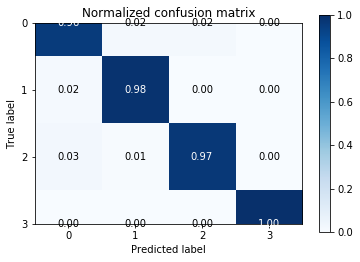

In [18]:
plot_confusion_matrix(CV1)

### Overall accuracy of cross-validation

We got 95% accuracy by using a simple spectral-normalization technique, without any hyper-parameter tuning or optimisation.

The accuracy is better than <a href="https://arxiv.org/pdf/1902.01012.pdf">IBM Research</a>, however we've used a random subset of data.

Further optimisation is currently underway, and the pipeline will then be tested on the full Temple-University dataset.

In [12]:
print("Balanced accuracy score is %0.2f +/- %0.3f" % (scores.mean(), scores.std()))

Balanced accuracy score is 0.98 +/- 0.008
